# Import Libraries

In [59]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import AdaBoostClassifier, IsolationForest, RandomForestClassifier, VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ttest_ind
from sklearn.manifold import TSNE
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Obtain Data

Read csv file with combine data into pandas

In [46]:
df = pd.read_csv('Data/Combine_Data.csv')
df.head()

,Year,Player,Position,School,College Stats,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump,3 Cone,Shuttle,Draft
0,2015,Ameer Abdullah,RB,Nebraska,College Stats,5-9,205.0,4.60,42.5,24.0,130.0,6.79,3.95,Detroit Lions / 2nd / 54th pick / 2015
1,2015,Nelson Agholor,WR,USC,College Stats,6-0,198.0,4.42,NaN,12.0,NaN,NaN,NaN,Philadelphia Eagles / 1st / 20th pick / 2015
2,2015,Jay Ajayi,RB,Boise State,College Stats,6-0,221.0,4.57,39.0,19.0,121.0,7.10,4.10,Miami Dolphins / 5th / 149th pick / 2015
3,2015,Kwon Alexander,OLB,LSU,College Stats,6-1,227.0,4.55,36.0,24.0,121.0,7.14,4.20,Tampa Bay Buccaneers / 4th / 124th pick / 2015
4,2015,Mario Alford,WR,West Virginia,College Stats,5-8,180.0,4.43,34.0,13.0,121.0,6.64,4.07,Cincinnati Bengals / 7th / 238th pick / 2015


Filter df to only include WR and CB Position players

In [47]:
df = df[(df['Position'] == 'WR') | (df['Position'] == 'CB')]
df.reset_index(drop=True, inplace=True)
print('df shape:', df.shape)
df.head()

df shape: (506, 14)


,Year,Player,Position,School,College Stats,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump,3 Cone,Shuttle,Draft
0,2015,Nelson Agholor,WR,USC,College Stats,6-0,198.0,4.42,NaN,12.0,NaN,NaN,NaN,Philadelphia Eagles / 1st / 20th pick / 2015
1,2015,Mario Alford,WR,West Virginia,College Stats,5-8,180.0,4.43,34.0,13.0,121.0,6.64,4.07,Cincinnati Bengals / 7th / 238th pick / 2015
2,2015,Dres Anderson,WR,Utah,College Stats,6-1,187.0,4.54,NaN,13.0,NaN,NaN,NaN,NaN
3,2015,Kenny Bell,WR,Nebraska,College Stats,6-1,197.0,4.42,41.5,7.0,129.0,6.66,4.15,Tampa Bay Buccaneers / 5th / 162nd pick / 2015
4,2015,Da'Ron Brown,WR,Northern Illinois,College Stats,6-0,205.0,4.54,37.0,17.0,120.0,7.04,4.11,Kansas City Chiefs / 7th / 233rd pick / 2015


# Scrub Data

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           506 non-null    int64  
 1   Player         506 non-null    object 
 2   Position       506 non-null    object 
 3   School         506 non-null    object 
 4   College Stats  464 non-null    object 
 5   Height         506 non-null    object 
 6   Weight         506 non-null    float64
 7   40 Yd Dash     453 non-null    float64
 8   Vertical       424 non-null    float64
 9   Bench          385 non-null    float64
 10  Broad Jump     420 non-null    float64
 11  3 Cone         299 non-null    float64
 12  Shuttle        309 non-null    float64
 13  Draft          318 non-null    object 
dtypes: float64(7), int64(1), object(6)
memory usage: 55.5+ KB


Drop columns not useful for modeling

In [49]:
df.drop(columns=['Draft', 'School', 'Player', 'College Stats', 'Year'], inplace=True)
df.head()

,Position,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump,3 Cone,Shuttle
0,WR,6-0,198.0,4.42,NaN,12.0,NaN,NaN,NaN
1,WR,5-8,180.0,4.43,34.0,13.0,121.0,6.64,4.07
2,WR,6-1,187.0,4.54,NaN,13.0,NaN,NaN,NaN
3,WR,6-1,197.0,4.42,41.5,7.0,129.0,6.66,4.15
4,WR,6-0,205.0,4.54,37.0,17.0,120.0,7.04,4.11


Change height units to inches and update to int data type

In [50]:
def feet_to_inches(val):
    return int(val.split('-')[0])*12 + int(val.split('-')[1])
df['Height'] = df['Height'].apply(feet_to_inches)
df.head()

,Position,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump,3 Cone,Shuttle
0,WR,72,198.0,4.42,NaN,12.0,NaN,NaN,NaN
1,WR,68,180.0,4.43,34.0,13.0,121.0,6.64,4.07
2,WR,73,187.0,4.54,NaN,13.0,NaN,NaN,NaN
3,WR,73,197.0,4.42,41.5,7.0,129.0,6.66,4.15
4,WR,72,205.0,4.54,37.0,17.0,120.0,7.04,4.11


Numerically code Position variable

In [51]:
df['Position'] = df['Position'].replace({'CB':0, 'WR':1})
df.head()

,Position,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump,3 Cone,Shuttle
0,1,72,198.0,4.42,NaN,12.0,NaN,NaN,NaN
1,1,68,180.0,4.43,34.0,13.0,121.0,6.64,4.07
2,1,73,187.0,4.54,NaN,13.0,NaN,NaN,NaN
3,1,73,197.0,4.42,41.5,7.0,129.0,6.66,4.15
4,1,72,205.0,4.54,37.0,17.0,120.0,7.04,4.11


Drop features missing more than one quarter of values

In [52]:
df.drop(columns=['3 Cone', 'Shuttle'], inplace=True)
df.head()

,Position,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump
0,1,72,198.0,4.42,NaN,12.0,NaN
1,1,68,180.0,4.43,34.0,13.0,121.0
2,1,73,187.0,4.54,NaN,13.0,NaN
3,1,73,197.0,4.42,41.5,7.0,129.0
4,1,72,205.0,4.54,37.0,17.0,120.0


Drop players missing 4 values

In [53]:
df = df[df.isna().sum(axis=1)<4]
print('df shape:', df.shape)
df.head()

df shape: (487, 7)


,Position,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump
0,1,72,198.0,4.42,NaN,12.0,NaN
1,1,68,180.0,4.43,34.0,13.0,121.0
2,1,73,187.0,4.54,NaN,13.0,NaN
3,1,73,197.0,4.42,41.5,7.0,129.0
4,1,72,205.0,4.54,37.0,17.0,120.0


Impute missing values

In [54]:
impute_x = df.drop(columns=['Position'])
impute_y = df['Position']
impute_x_train, impute_x_test, impute_y_train, impute_y_test = train_test_split(impute_x, impute_y, test_size=0.2,
                                                                                random_state=73)
impute_ss = StandardScaler()
impute_ss.fit(impute_x_train)
impute_x_train = pd.DataFrame(impute_ss.transform(impute_x_train), columns=impute_x_train.columns, 
                              index=impute_x_train.index)
impute_x_test = pd.DataFrame(impute_ss.transform(impute_x_test), columns=impute_x_test.columns, 
                             index=impute_x_test.index)

imputer = KNNImputer()
imputer.fit(impute_x_train)
impute_x_train = pd.DataFrame(imputer.transform(impute_x_train), columns=impute_x_train.columns, 
                              index=impute_x_train.index)
impute_x_test = pd.DataFrame(imputer.transform(impute_x_test), columns=impute_x_test.columns, 
                             index=impute_x_test.index)

impute_x_train = pd.DataFrame(impute_ss.inverse_transform(impute_x_train), columns=impute_x_train.columns, 
                              index=impute_x_train.index)
impute_x_test = pd.DataFrame(impute_ss.inverse_transform(impute_x_test), columns=impute_x_test.columns, 
                             index=impute_x_test.index)

df = pd.concat([impute_x_train, impute_x_test])
df.sort_index(inplace=True)
df['Position'] = impute_y
df.head()

,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump,Position
0,72.0,198.0,4.42,37.9,12.0,125.6,1
1,68.0,180.0,4.43,34.0,13.0,121.0,1
2,73.0,187.0,4.54,37.5,13.0,126.6,1
3,73.0,197.0,4.42,41.5,7.0,129.0,1
4,72.0,205.0,4.54,37.0,17.0,120.0,1


Confirm data now scrubbed with df.info()

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487 entries, 0 to 505
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Height      487 non-null    float64
 1   Weight      487 non-null    float64
 2   40 Yd Dash  487 non-null    float64
 3   Vertical    487 non-null    float64
 4   Bench       487 non-null    float64
 5   Broad Jump  487 non-null    float64
 6   Position    487 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 30.4 KB


# Explore Data

Find training set outlier datapoints

In [12]:
outlier_x = df.drop(columns='Position')
outlier_y = df['Position']
outlier_x_train, outlier_x_test, outlier_y_train, outlier_y_test = train_test_split(outlier_x, outlier_y, 
                                                                                    test_size=0.2, random_state=73)

outlier_ss = StandardScaler()
outlier_ss.fit(outlier_x_train)
outlier_x_train = pd.DataFrame(outlier_ss.transform(outlier_x_train), columns=outlier_x_train.columns, 
                              index=outlier_x_train.index)
outlier_x_test = pd.DataFrame(outlier_ss.transform(outlier_x_test), columns=outlier_x_test.columns, 
                             index=outlier_x_test.index)

isf = IsolationForest(contamination=.02)
isf.fit(outlier_x_train)
outlier_x_train['Outlier'] = isf.predict(outlier_x_train)
outlier_x_train[outlier_x_train['Outlier']==-1].round(2)

,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump,Outlier
38,0.27,-0.05,-0.88,3.13,-0.27,4.44,-1
154,0.76,2.28,2.35,-1.99,0.00,-0.34,-1
209,-0.23,-0.75,2.58,-1.99,-1.10,-1.99,-1
368,0.76,2.20,0.24,1.01,3.58,-0.16,-1
338,1.74,1.58,-0.99,2.77,-0.55,3.15,-1
11,0.76,1.03,-1.77,3.30,1.10,2.97,-1
70,2.73,2.98,-0.54,0.48,-0.55,0.40,-1
317,2.24,2.20,1.91,-1.64,0.55,-1.99,-1


Replace all datapoints greater than 3 training standard deviations from the training mean with 3 standard deviation value

In [13]:
replace_x = df.drop(columns='Position')
replace_y = df['Position']
replace_x_train, replace_x_test, replace_y_train, replace_y_test = train_test_split(replace_x, replace_y, 
                                                                                    test_size=0.2, random_state=73)

replace_ss = StandardScaler()
replace_ss.fit(replace_x_train)
replace_x_train = pd.DataFrame(replace_ss.transform(replace_x_train), columns=replace_x_train.columns, 
                              index=replace_x_train.index)
replace_x_test = pd.DataFrame(replace_ss.transform(replace_x_test), columns=replace_x_test.columns, 
                             index=replace_x_test.index)

def replace_outliers(row):
    output = []
    for val in row.values:
        if val > 3:
            output.append(3)
        elif val < -3:
            output.append(-3)
        else:
            output.append(val)
    return output

replace_x_train = pd.DataFrame(replace_x_train.apply(replace_outliers, axis=0), index=replace_x_train.index, 
                               columns=replace_x_train.columns)
replace_x_train = pd.DataFrame(replace_ss.inverse_transform(replace_x_train), index=replace_x_train.index, 
                               columns=replace_x_train.columns)
replace_x_train['Position'] = replace_y_train


replace_x_test = pd.DataFrame(replace_x_test.apply(replace_outliers, axis=0), index=replace_x_test.index, 
                               columns=replace_x_test.columns)
replace_x_test = pd.DataFrame(replace_ss.inverse_transform(replace_x_test), index=replace_x_test.index, 
                               columns=replace_x_test.columns)
replace_x_test['Position'] = replace_y_test

df = pd.concat([replace_x_train, replace_x_test])
df.sort_index(inplace=True)
df.head()

,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump,Position
0,72.0,198.0,4.42,37.9,12.0,125.6,1
1,68.0,180.0,4.43,34.0,13.0,121.0,1
2,73.0,187.0,4.54,37.5,13.0,126.6,1
3,73.0,197.0,4.42,41.5,7.0,129.0,1
4,72.0,205.0,4.54,37.0,17.0,120.0,1


Calculate descriptive statistics for each variable

In [14]:
df.describe().round(2)

,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump,Position
count,487.00,487.00,487.00,487.00,487.00,487.00,487.00
mean,72.40,199.52,4.51,35.52,14.05,122.56,0.57
std,2.07,13.07,0.09,2.89,3.59,5.46,0.50
min,67.00,161.04,4.24,27.14,4.00,108.00,0.00
25%,71.00,190.00,4.45,33.50,12.00,119.00,0.00
50%,72.00,198.00,4.51,35.50,14.00,122.00,1.00
75%,74.00,208.00,4.57,37.00,16.20,125.00,1.00
max,78.00,238.31,4.78,44.14,24.91,139.17,1.00


Plot Position class distribution

Text(0, 0.5, 'Count')

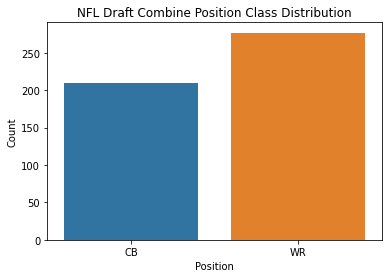

In [15]:
fig, ax = plt.subplots()
sns.countplot(x='Position',data=df)
ax.set_title('NFL Draft Combine Position Class Distribution')
ax.set_xticklabels(['CB', 'WR'])
ax.set_ylabel('Count')

Plot distribution for each feature in NFL Draft Combine dataset

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

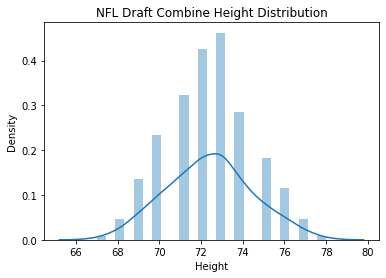

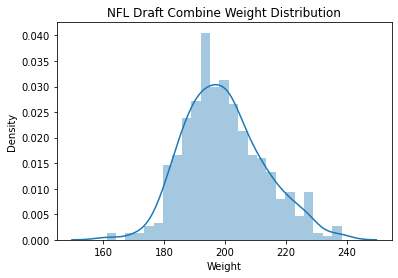

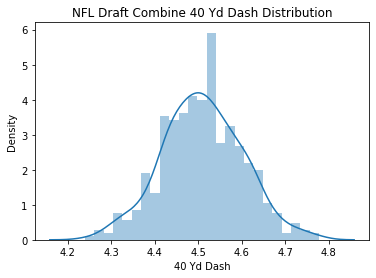

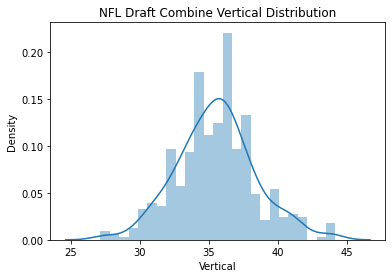

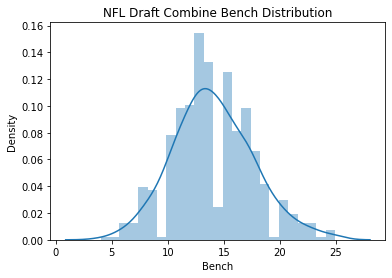

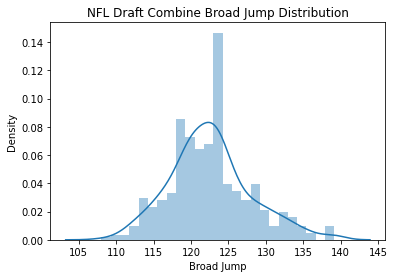

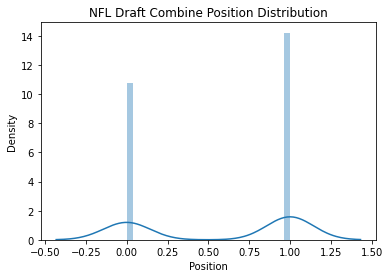

In [16]:
for feature in df.columns:
    fig1, ax1 = plt.subplots()
    sns.distplot(df[feature], kde=True, bins=25, ax=ax1)
    ax1.set_title(f'NFL Draft Combine {feature} Distribution')

Calculate vif for each feature to find correlated features

In [17]:
vif_x = df.drop(columns=['Position'])
vif_y = df['Position']
vif_x_train, vif_x_test, vif_y_train, vif_y_test = train_test_split(vif_x, vif_y, test_size=0.2, random_state=73)
vif_df = add_constant(vif_x_train)


vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
vif_output_df = pd.DataFrame(vif_output, columns=['Column', 'VIF'])
vif_output_df.sort_values(by='VIF', ascending=False, inplace=True)
vif_output_df.round(decimals=1).reset_index(drop=True)

,Column,VIF
0,const,5601.0
1,Weight,2.2
2,Height,2.0
3,Broad Jump,1.9
4,Vertical,1.8
5,40 Yd Dash,1.3
6,Bench,1.3


Run t test for each feature to determine if there is a statistically significant difference between classes

In [18]:
ttest_x = df.drop(columns=['Position'])
ttest_y = df[['Position']]
ttest_x_train, ttest_x_test, ttest_y_train, ttest_y_test = train_test_split(ttest_x, ttest_y, test_size=0.2,
                                                                                random_state=73)
ttest = pd.concat([ttest_x_train, ttest_y_train], axis=1)

for feat in ttest_x.columns:
    print(f'{feat}: ')
    print('CB Mean: ', df[df['Position']==0][feat].mean())
    print('WR Mean: ', df[df['Position']==1][feat].mean())
    print('Difference', str(round(df[df['Position']==0][feat].mean()/df[df['Position']==1][feat].mean()-1, 4)*100)+'%')
    print(ttest_ind(ttest[ttest['Position']==0][feat].values, ttest[ttest['Position']==1][feat].values))
    print('')

Height: 
CB Mean:  71.70952380952382
WR Mean:  72.92057761732852
Difference -1.66%
Ttest_indResult(statistic=-6.391944733500643, pvalue=4.716423490988421e-10)

Weight: 
CB Mean:  193.8095238095238
WR Mean:  203.84616450193056
Difference -4.92%
Ttest_indResult(statistic=-8.582956399948694, pvalue=2.274167064065655e-16)

40 Yd Dash: 
CB Mean:  4.499409523809524
WR Mean:  4.517962970042093
Difference -0.41000000000000003%
Ttest_indResult(statistic=-1.2789179260820758, pvalue=0.2016923068626863)

Vertical: 
CB Mean:  35.86304617195978
WR Mean:  35.26304511243307
Difference 1.7000000000000002%
Ttest_indResult(statistic=1.2658072381830006, pvalue=0.20634358813320944)

Bench: 
CB Mean:  14.0262230528629
WR Mean:  14.07369560361884
Difference -0.33999999999999997%
Ttest_indResult(statistic=-0.7141616013294558, pvalue=0.4755577677579891)

Broad Jump: 
CB Mean:  123.3741245631045
WR Mean:  121.95138020398518
Difference 1.17%
Ttest_indResult(statistic=2.235935987207626, pvalue=0.02592541689511932

In [19]:
tsne_x = df.drop(columns=['Position', '40 Yd Dash', 'Bench', 'Vertical'])
tsne_y = df[['Position']]
tsne_x_train, tsne_x_test, tsne_y_train, tsne_y_test = train_test_split(tsne_x, tsne_y, test_size=0.2,
                                                                                random_state=73)

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=2000)
tsne_output = tsne.fit_transform(tsne_x_train)
tsne_df = pd.DataFrame(tsne_output, columns = ['d1', 'd2'])
tsne_df.head()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 389 samples in 0.002s...
[t-SNE] Computed neighbors for 389 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 389 / 389
[t-SNE] Mean sigma: 3.816177
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.627266
[t-SNE] KL divergence after 950 iterations: 0.363297


,d1,d2
0,15.518286,-10.648542
1,13.644543,-11.632759
2,-7.391177,6.064359
3,-10.942030,5.927160
4,-13.431305,8.032652


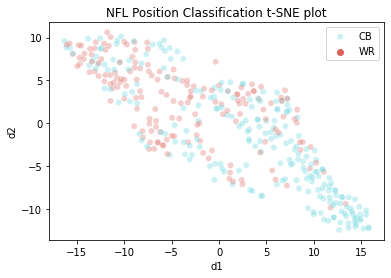

In [20]:
tsne_plot = sns.scatterplot(
    x="d1", y="d2",
    hue=tsne_y_train['Position'].values,
    palette=sns.color_palette("hls", 2),
    data=tsne_df,
    legend="full",
    alpha=0.3)
tsne_plot.set_title('NFL Position Classification t-SNE plot')
tsne_plot.legend(['CB', 'WR'])

# Model Data

Create x and y variables

In [21]:
x = df.drop(columns=['Position', '40 Yd Dash', 'Bench', 'Vertical'])
y = df['Position']
x.head()

,Height,Weight,Broad Jump
0,72.0,198.0,125.6
1,68.0,180.0,121.0
2,73.0,187.0,126.6
3,73.0,197.0,129.0
4,72.0,205.0,120.0


Perform train test split on x and y variables

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=73)
x_train.head()

,Height,Weight,Broad Jump
346,77.0,227.0,128.0
341,72.0,226.0,120.0
394,71.0,190.0,120.0
190,70.0,186.0,122.0
133,70.0,181.0,121.0


Standard scale x variable

In [23]:
ss = StandardScaler()
ss.fit(x_train)
x_train = pd.DataFrame(ss.transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(ss.transform(x_test), columns=x_test.columns, index=x_test.index)
x_train.head()

,Height,Weight,Broad Jump
346,2.235260,2.123139,0.969250
341,-0.226564,2.045436,-0.528493
394,-0.718929,-0.751869,-0.528493
190,-1.211293,-1.062680,-0.154057
133,-1.211293,-1.451195,-0.341275


Build and validate dummy classifier

In [24]:
dc = DummyClassifier(strategy='stratified', random_state=77)
dc.fit(x_train, y_train)
y_train_pred_dc = dc.predict(x_train)
y_test_pred_dc = dc.predict(x_test)
print('Dummy Classifier')
print('Train f1 score: ', f1_score(y_train, y_train_pred_dc))
print('Train Accuracy score: ', accuracy_score(y_train, y_train_pred_dc))
print('Test f1 score: ', f1_score(y_test, y_test_pred_dc))
print('Test Accuracy score: ', accuracy_score(y_test, y_test_pred_dc))

Dummy Classifier
Train f1 score:  0.5757575757575758
Train Accuracy score:  0.4961439588688946
Test f1 score:  0.5811965811965812
Test Accuracy score:  0.5


Create confusion matrix for dummy classifier

[Text(0, 0.5, 'CB'), Text(0, 1.5, 'WR')]

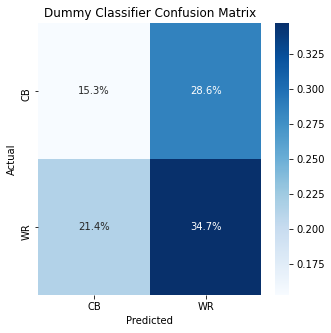

In [25]:
dc_cm = confusion_matrix(y_test, y_test_pred_dc)
fig, ax = plt.subplots(figsize=(5,5))
dc_matrix = sns.heatmap(dc_cm/np.sum(dc_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
dc_matrix.set_title('Dummy Classifier Confusion Matrix')
dc_matrix.set_xlabel('Predicted')
dc_matrix.set_xticklabels(['CB','WR'])
dc_matrix.set_ylabel('Actual')
dc_matrix.set_yticklabels(['CB','WR'])

Gridsearch logistic regression model

In [26]:
gs_lr_dict = {'C': [x/1000 for x in range(1, 2001)]}
gs_lr_model = LogisticRegression(random_state=1)
gs_lr = GridSearchCV(gs_lr_model, gs_lr_dict, scoring='f1', n_jobs=1, cv=5, verbose=1)
gs_lr.fit(x_train, y_train)
print(gs_lr.best_params_)
print(gs_lr.best_score_)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
{'C': 0.632}
0.7346153846153847


Fit and evaluate top performing logistic regression model from gridsearch

In [31]:
lr = LogisticRegression(C=.632, random_state=1)
lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)
print('Logistic Regression')
print('Train f1 score: ', f1_score(y_train, y_train_pred_lr))
print('Train Accuracy score: ', accuracy_score(y_train, y_train_pred_lr))
print('Test f1 score: ', f1_score(y_test, y_test_pred_lr))
print('Test Accuracy score: ', accuracy_score(y_test, y_test_pred_lr))

Logistic Regression
Train f1 score:  0.7331887201735359
Train Accuracy score:  0.6838046272493573
Test f1 score:  0.7027027027027026
Test Accuracy score:  0.6632653061224489


Create confusion matrix for logistic regression

[Text(0, 0.5, 'CB'), Text(0, 1.5, 'WR')]

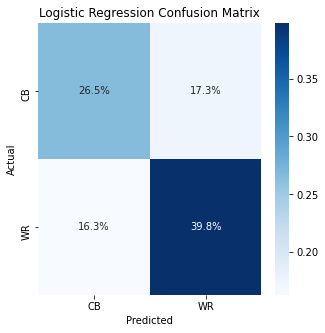

In [28]:
lr_cm = confusion_matrix(y_test, y_test_pred_lr)
fig, ax = plt.subplots(figsize=(5,5))
lr_matrix = sns.heatmap(lr_cm/np.sum(lr_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
lr_matrix.set_title('Logistic Regression Confusion Matrix')
lr_matrix.set_xlabel('Predicted')
lr_matrix.set_xticklabels(['CB','WR'])
lr_matrix.set_ylabel('Actual')
lr_matrix.set_yticklabels(['CB','WR'])

Gridsearch Adaboost model

In [29]:
gs_ab_dict = {'learning_rate': [x/1000 for x in range(1, 2001)]}
gs_ab_model = AdaBoostClassifier(random_state=94)
gs_ab = GridSearchCV(gs_ab_model, gs_ab_dict, scoring='f1', n_jobs=1, cv=5, verbose=1)
gs_ab.fit(x_train, y_train)
print(gs_ab.best_params_)
print(gs_ab.best_score_)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
{'learning_rate': 0.068}
0.7414487844122425


Fit and evaluate top performing adaboost model from gridsearch

In [30]:
ab = AdaBoostClassifier(random_state=94, learning_rate=.068)
ab.fit(x_train, y_train)
y_train_pred_ab = ab.predict(x_train)
y_test_pred_ab = ab.predict(x_test)
print('AdaBoost')
print('Train f1 score: ', f1_score(y_train, y_train_pred_ab))
print('Train Accuracy score: ', accuracy_score(y_train, y_train_pred_ab))
print('Test f1 score: ', f1_score(y_test, y_test_pred_ab))
print('Test Accuracy score: ', accuracy_score(y_test, y_test_pred_ab))

AdaBoost
Train f1 score:  0.7579908675799087
Train Accuracy score:  0.7275064267352185
Test f1 score:  0.6915887850467289
Test Accuracy score:  0.6632653061224489


Create confusion matrix for adaboost

[Text(0, 0.5, 'CB'), Text(0, 1.5, 'WR')]

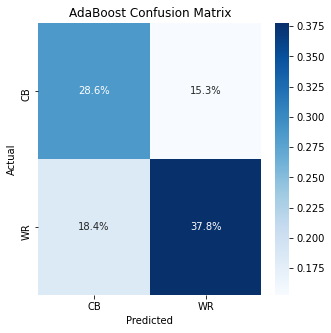

In [73]:
lr_cm = confusion_matrix(y_test, y_test_pred_ab)
fig, ax = plt.subplots(figsize=(5,5))
lr_matrix = sns.heatmap(lr_cm/np.sum(lr_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
lr_matrix.set_title('AdaBoost Confusion Matrix')
lr_matrix.set_xlabel('Predicted')
lr_matrix.set_xticklabels(['CB','WR'])
lr_matrix.set_ylabel('Actual')
lr_matrix.set_yticklabels(['CB','WR'])

Gridsearch Random Forest model

In [69]:
gs_rf_dict = {'max_features': [.33, .66, .99],
             'max_samples': [.91, .92, .93, .94, .95],
             'min_samples_split': [.53, .54, .55, .56, .57],
             'criterion': ['gini', 'entropy']}
gs_rf_model = RandomForestClassifier(random_state=21)
gs_rf = GridSearchCV(estimator=gs_rf_model, param_grid=gs_rf_dict, scoring='f1', n_jobs=-1, cv=5, verbose=1)
gs_rf.fit(x_train, y_train)
print('Random Forest')
print('Best score:', gs_rf.best_score_)
print('Best params:', gs_rf.best_params_)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Random Forest
Best score: 0.7635169493423345
Best params: {'criterion': 'gini', 'max_features': 0.33, 'max_samples': 0.93, 'min_samples_split': 0.55}


Fit and evaluate top performing random forest model from gridsearch

In [72]:
rf = RandomForestClassifier(random_state=21, criterion='gini', max_features= .33, max_samples=.93, 
                        min_samples_split=.55)
rf.fit(x_train, y_train)
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)
print('Random Forest')
print('Train f1 score: ', f1_score(y_train, y_train_pred_rf))
print('Train Accuracy score: ', accuracy_score(y_train, y_train_pred_rf))
print('Test f1 score: ', f1_score(y_test, y_test_pred_rf))
print('Test Accuracy score: ', accuracy_score(y_test, y_test_pred_rf))

Random Forest
Train f1 score:  0.768888888888889
Train Accuracy score:  0.7326478149100257
Test f1 score:  0.7027027027027026
Test Accuracy score:  0.6632653061224489


Create confusion matrix for random forest

[Text(0, 0.5, 'CB'), Text(0, 1.5, 'WR')]

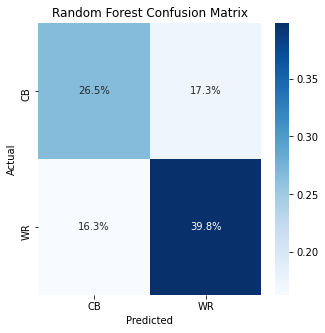

In [75]:
lr_cm = confusion_matrix(y_test, y_test_pred_rf)
fig, ax = plt.subplots(figsize=(5,5))
lr_matrix = sns.heatmap(lr_cm/np.sum(lr_cm), annot=True, ax = ax, cmap = 'Blues', fmt = '.1%')
lr_matrix.set_title('Random Forest Confusion Matrix')
lr_matrix.set_xlabel('Predicted')
lr_matrix.set_xticklabels(['CB','WR'])
lr_matrix.set_ylabel('Actual')
lr_matrix.set_yticklabels(['CB','WR'])